In [1]:
import nltk
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn
from time import time

In [2]:
#We first fix the seed to be sure that the test set is always the same
np.random.seed(1)
torch.manual_seed(1)

# Part 1 : shaping data

Useful functions

In [3]:
def reshape_data(corpus):
    #data must be in a list as follow : [(sentence,tags),(sentence, tags)...]
    data_set=[]
    for sentence in corpus :
        words = [w[0] for w in sentence]
        tags = [w[1] for w in sentence]
        data_set.append((words,tags))
    return(data_set)

def split_data(corpus,train_length,val_length,test_length) :
    if train_length+val_length+test_length <= len(corpus) :
        training_set = corpus[:train_length]
        validaiton_set = corpus[train_length:train_length+val_length]
        test_set = corpus[train_length+val_length:train_length+val_length+test_length]
        return(training_set,validaiton_set,test_set)
    else:
        return('not enough sentences in the dataset')

def prepare_sequence(seq, to_ix):
    #turn the words of a sentence into its word dictionary index
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return autograd.Variable(tensor)

def long_sentences(corpus,n_sent,n_words) :
    """return n_sent sentences with more than n_words"""
    long_sent = []
    for sentence in corpus :
        if len(sentence[0])>n_words :
            long_sent.append(sentence)
    if len(long_sent)>=n_sent :
        return(long_sent[:n_sent])
    else :
        print("not enough long sentences")
        return(long_sent)
    
def short_sentences(corpus,n_sent,n_words) :
    """return n_sent sentences with less than n_words"""
    short_sent = []
    for sentence in corpus :
        if len(sentence[0])<n_words :
            short_sent.append(sentence)
    if len(short_sent)>=n_sent :
        return(short_sent[:n_sent])
    else :
        print("not enough short sentences")
        return(short_sent)

def generate_tag_dic(tagged_sent):
    tags=[]
    [tags.extend([item[1] for item in tagged_sent[i]]) for i in range(len(tagged_sent))]
    tags_unique = set(tags)
    tag_to_ix = dict(zip(tags_unique, range(len(tags_unique))))
    return tag_to_ix

def generate_word_dic(tagged_sent):
    words=[]
    [words.extend([item[0] for item in tagged_sent[i]]) for i in range(len(tagged_sent))]
    words_unique = set(words)
    word_to_ix = dict(zip(words_unique, range(len(words_unique))))
    return word_to_ix

Creating the sets

In [4]:
#nltk.download('brown')
#importing the brown corpus from nltk
tagged_sent = nltk.corpus.brown.tagged_sents()

In [5]:
data_set = reshape_data(tagged_sent)
#shuffle the data_set to be sure sentences are of random lengths
np.random.shuffle(data_set)

#make the training, validation and test set
train_l = 5000
val_l = 2000
test_l = 1000
total = train_l+val_l+test_l

training_set,validation_set,test_set = split_data(data_set,train_l,val_l,test_l)

#add a test set with short sentences (less than 5 words)
short_test_set = short_sentences(data_set[total:],test_l,5)
#add a test set with long sentences (more than 40 words)
long_test_set = long_sentences(data_set[total:],test_l,40)

Creating dictionaries

In [6]:
word_to_ix = generate_word_dic(tagged_sent)
tag_dic = generate_tag_dic(tagged_sent)

# Part 2 : LSTM architectures

In [7]:
# from http://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

#network dimensions
EMBEDDING_DIM = 300
HIDDEN_DIM = 200

In [8]:
class LSTMTagger(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        
        self.hidden2tag = nn.Linear(hidden_dim, target_size)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return(autograd.Variable(torch.zeros(1, 1, self.hidden_dim)),
              autograd.Variable(torch.zeros(1, 1, self.hidden_dim)))
    
    def forward(self, sentence):
        embeds = self.word_embedding(sentence)
        lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return(tag_scores)

In [9]:
class LSTMTagger_bidir(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTMTagger_bidir, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = True)
        
        self.hidden2tag = nn.Linear(2*hidden_dim, target_size)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return(autograd.Variable(torch.zeros(2, 1, self.hidden_dim)),
              autograd.Variable(torch.zeros(2, 1, self.hidden_dim)))
    
    def forward(self, sentence):
        embeds = self.word_embedding(sentence)
        lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return(tag_scores)

In [10]:
class LSTMTagger_2layers(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTMTagger_2layers, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = 2)
        
        self.hidden2tag = nn.Linear(hidden_dim, target_size)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return(autograd.Variable(torch.zeros(2, 1, self.hidden_dim)),
              autograd.Variable(torch.zeros(2, 1, self.hidden_dim)))
    
    def forward(self, sentence):
        embeds = self.word_embedding(sentence)
        lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return(tag_scores)

In [11]:
class LSTMTagger_bidir_2layers(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTMTagger_bidir_2layers, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = 2, bidirectional = True)
        
        self.hidden2tag = nn.Linear(2*hidden_dim, target_size)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return(autograd.Variable(torch.zeros(4, 1, self.hidden_dim)),
              autograd.Variable(torch.zeros(4, 1, self.hidden_dim)))
    
    def forward(self, sentence):
        embeds = self.word_embedding(sentence)
        lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return(tag_scores)

# Part 3 : training the networks and making predictions

In [12]:
def training_net(training_set,model) :
    
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    
    #shuffle the data at before each training loop
    np.random.shuffle(training_set)
    
    for sentence, tags in training_set:
        #clear the gradient before each instance
        model.zero_grad()
        #clear out the hidden state of the lstm
        #detaching it from its history on the last instance
        model.hidden = model.init_hidden()
        
        #get the inputs ready for the network : turn them into variable of word indices
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_dic)
        
        #forward pass
        tag_scores = model(sentence_in)

        #compute loss, gradient, and update the parameters 
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

In [13]:
def running_net(data_set,model) :
    np.random.shuffle(data_set)
    f1score = []
    
    for sentence, tags in data_set :
        model.zero_grad()
        model.hidden = model.init_hidden()
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_dic)
        
        #making predictions
        _,tags_predictions = torch.max(model(sentence_in), dim=1)

        #store predictions
        #for each word, one if it's the good tag, 0 otherwise
        sentence_prediction = [1 if int(tags_predictions[i])==int(targets[i]) else 0 for i in range(len(targets))]
            
        #computing f1
        array_target = targets.data.numpy()
        array_pred = tags_predictions.data.numpy()
        f1score.append(sklearn.metrics.f1_score(array_target,array_pred,average='micro'))
                                                     
    return(np.average(f1score))

In [14]:
def main (n_epochs,model):
    
    #training network
    loss = 0 #initialize the loss for the training_net function
    validation_f1score = [] #list of all the f1 score computed on the validation set
    
    for epoch in range(n_epochs):
        print("epoch n°" + str(epoch))
        training_net(training_set,model)
        epoch_score = running_net(validation_set,model)
        validation_f1score.append(epoch_score)
    
    #test network
    print('computing tests')
    test_score = running_net(test_set,model)
    test_score_short = running_net(short_test_set,model)
    test_score_long = running_net(long_test_set,model)

    return(validation_f1score,test_score,test_score_short,test_score_long)

simple lstm

epoch n°0
epoch n°1
epoch n°2
epoch n°3
epoch n°4
epoch n°5
epoch n°6
epoch n°7
epoch n°8
epoch n°9
computing tests
training time
3179.4441392421722s
f1 score computed on the test set, with long sentences
0.8411731485520356
f1 score computed on the test set, with short sentences
0.5343333333333332
f1 score computed on the test set
0.8203218083854477


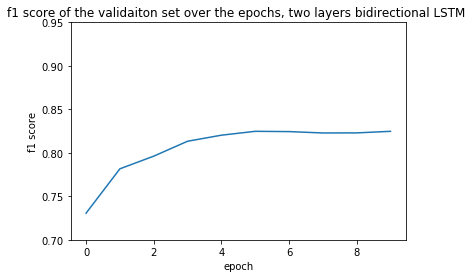

In [15]:
model_lstm = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_dic))

t1 = time()
validation_lstm,test_score_lstm,test_score_short_lstm,test_score_long_lstm = main(10,model_lstm)
t2 = time()

print('training time')
print(str(t2-t1)+"s")

plt.plot(validation_lstm)
plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.ylim(0.70,0.95)
plt.title('f1 score of the validaiton set over the epochs, two layers bidirectional LSTM ')
#plt.savefig("f1_score_2bilayerslstm.pdf")

print('f1 score computed on the test set, with long sentences')
print(test_score_long_lstm)

print('f1 score computed on the test set, with short sentences')
print(test_score_short_lstm)

print('f1 score computed on the test set')
print(test_score_lstm)

bidirectional lstm

epoch n°0
epoch n°1
epoch n°2
epoch n°3
epoch n°4
epoch n°5
epoch n°6
epoch n°7
epoch n°8
epoch n°9
computing tests
training time
4398.096567392349s
f1 score computed on the test set, with long sentences
0.8668655247381268
f1 score computed on the test set, with short sentences
0.60475
f1 score computed on the test set
0.8512876949999867


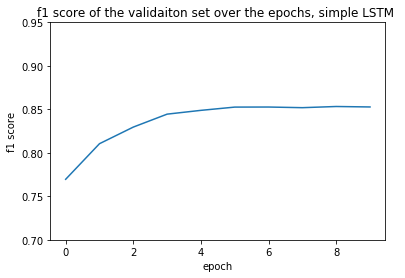

In [16]:
model_bidir = LSTMTagger_bidir(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_dic))

t1 = time()
validation_bidir,test_score_bidir,test_score_short_bidir,test_score_long_bidir = main(10,model_bidir)
t2 = time()

print('training time')
print(str(t2-t1)+"s")

plt.plot(validation_bidir)
plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.ylim(0.70,0.95)
plt.title('f1 score of the validaiton set over the epochs, simple LSTM ')
#plt.savefig("f1_score_lstm.pdf")

print('f1 score computed on the test set, with long sentences')
print(test_score_long_bidir)

print('f1 score computed on the test set, with short sentences')
print(test_score_short_bidir)

print('f1 score computed on the test set')
print(test_score_bidir)

two layers lstm

epoch n°0
epoch n°1
epoch n°2
epoch n°3
epoch n°4
epoch n°5
epoch n°6
epoch n°7
epoch n°8
epoch n°9
computing tests
training time
4552.989136695862s
f1 score computed on the test set, with long sentences
0.8669960918019767
f1 score computed on the test set, with short sentences
0.5995
f1 score computed on the test set
0.8502170152054678


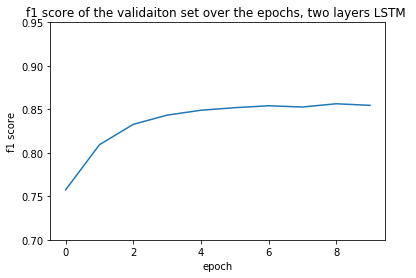

In [17]:
model_2lay = LSTMTagger_bidir(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_dic))

t1 = time()
validation_2lay,test_score_2lay,test_score_short_2lay,test_score_long_2lay = main(10,model_2lay)
t2 = time()

print('training time')
print(str(t2-t1)+"s")

plt.plot(validation_2lay)
plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.ylim(0.70,0.95)
plt.title('f1 score of the validaiton set over the epochs, two layers LSTM ')
#plt.savefig("f1_score_2lay.pdf")

print('f1 score computed on the test set, with long sentences')
print(test_score_long_2lay)

print('f1 score computed on the test set, with short sentences')
print(test_score_short_2lay)

print('f1 score computed on the test set')
print(test_score_2lay)

two layers bidirectional

epoch n°0
epoch n°1
epoch n°2
epoch n°3
epoch n°4
epoch n°5
epoch n°6
epoch n°7
epoch n°8
epoch n°9
computing tests
training time
7106.172688961029s
f1 score computed on the test set, with long sentences
0.8749527306940335
f1 score computed on the test set, with short sentences
0.6385833333333333
f1 score computed on the test set
0.8588055283914234


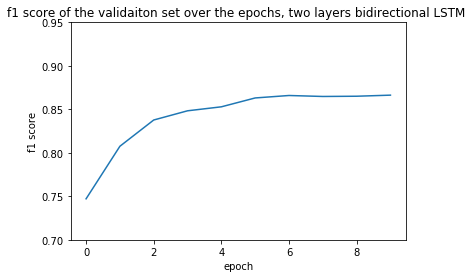

In [18]:
np.random.seed(seed = None)

model_bidir_2layers = LSTMTagger_bidir_2layers(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_dic))

t1 = time()
validation_bidir_2layers,test_score_bidir_2layers,test_score_short_bidir_2layers,test_score_long_bidir_2layers = main(10,model_bidir_2layers)
t2 = time()

print('training time')
print(str(t2-t1)+"s")

plt.plot(validation_bidir_2layers)
plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.ylim(0.70,0.95)
plt.title('f1 score of the validaiton set over the epochs, two layers bidirectional LSTM ')
#plt.savefig("f1_score_2bilayerslstm.pdf")

print('f1 score computed on the test set, with long sentences')
print(test_score_long_bidir_2layers)

print('f1 score computed on the test set, with short sentences')
print(test_score_short_bidir_2layers)

print('f1 score computed on the test set')
print(test_score_bidir_2layers)